Saving z6405888080633_95fa52cfc628f5baedc83fb4c8d175f5.jpg to z6405888080633_95fa52cfc628f5baedc83fb4c8d175f5.jpg


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


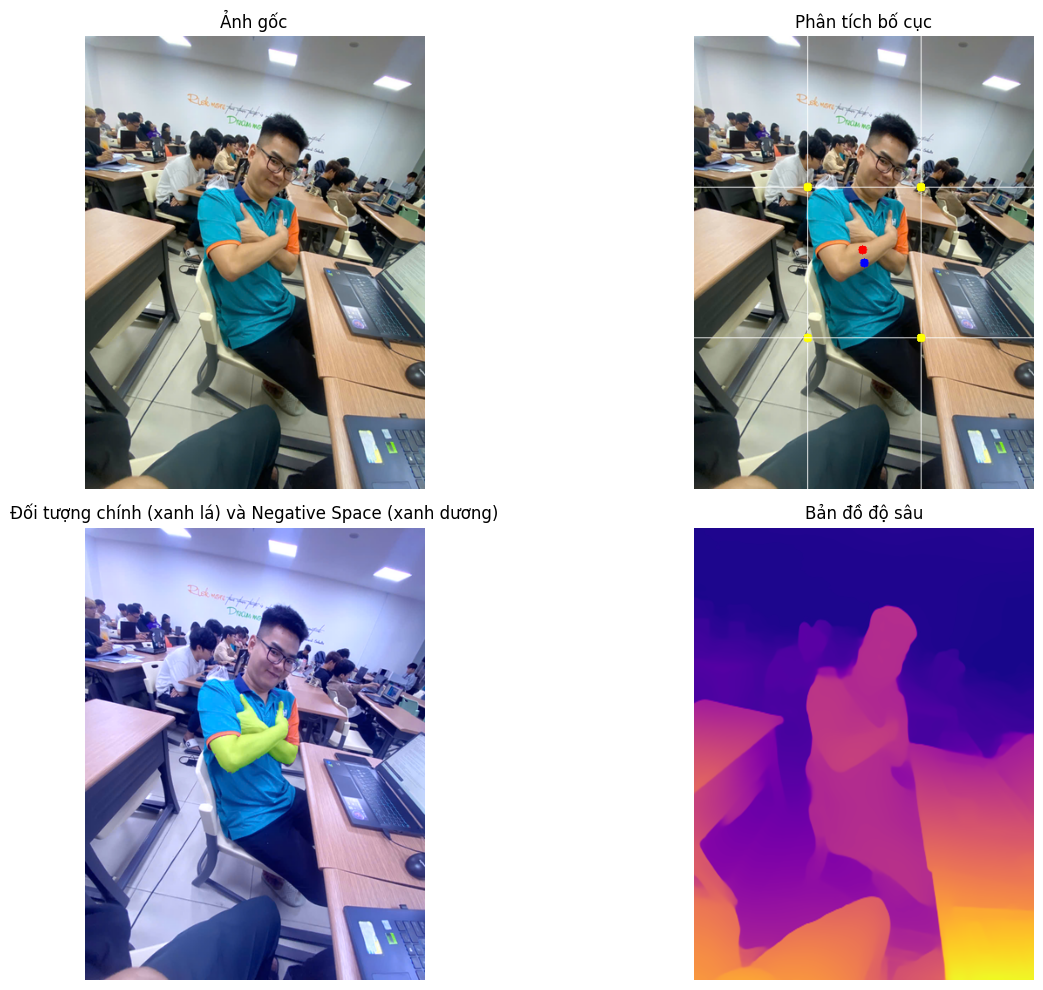

Phân tích bố cục:
- Vị trí trung tâm: (193, 245)
- Tỷ lệ kích thước: 2.14%

Đánh giá bố cục:
- Kiểu bố cục: Bố cục trung tâm
- Quy tắc 1/3: Không
- Đối xứng: Không
- Ở trung tâm: Có
- Khuyến nghị cải thiện: Vị trí hoàn hảo ở trung tâm ảnh!

Phân tích Negative Space:
- Tỷ lệ diện tích: 97.86%
- Đánh giá: Khả năng cao đây là ảnh thuộc trường phái minimalists với negative space chiếm ưu thế.


In [ ]:
import torch, os, cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from scipy import ndimage
from google.colab import files

# Install required libraries
try:
    from segment_anything import sam_model_registry, SamPredictor
except ModuleNotFoundError:
    !pip install git+https://github.com/facebookresearch/segment-anything.git
    from segment_anything import sam_model_registry, SamPredictor

# Download SAM model if needed
sam_checkpoint = "sam_vit_h_4b8939.pth"
if not os.path.exists(sam_checkpoint):
    !wget -O sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Tạo device để load model (SAM và MiDaS) vô

def load_models():
    # Load SAM model
    sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint) #Vision Transformer - Huge, còn bản Base với Large
    sam.to(device)
    sam_predictor = SamPredictor(sam) #Gọi giao diện, có thể dùng các hàm như .set_image()

    # Load MiDaS depth model
    midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large") #Dense Prediction Transformer, còn 2 bản là Base và Hybrid
    midas.to(device)
    midas.eval()

    return sam_predictor, midas

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)

    # Resize keeping aspect ratio
    width, height = img.size
    ratio = min(520 / width, 520 / height)
    new_size = (int(width * ratio), int(height * ratio))
    resized_img = img.resize(new_size, Image.LANCZOS) #Dùng LANCZOS để resize ảnh theo ratio

    # Process for MiDaS
    midas_transform = transforms.Compose([ #Hàm để biến đổi tuần tự
        transforms.ToTensor(), #chuyển từ array numpy sang tensor pytorch (H,W,C) sang (C,H,W), chuẩn hoá pixel [0,1]
        transforms.Resize((384, 384), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #Chuyển [0;1] sang [-1;1] Trong đó -1 là không lấy, 0 là background, 1 là foreground
    ])
    midas_input = midas_transform(img).unsqueeze(0).to(device) #Thêm batch dimension, chuyển từ [C, H, W] thành [1, C, H, W] (đầu vào midas xử lý theo từng batch)

    return {
        'original': img, 'array': img_array,
        'resized': resized_img, 'resized_array': np.array(resized_img),
        'midas_input': midas_input
    }

def generate_depth_map(midas, img_data):
    with torch.no_grad(): #Tắt gradient vì chỉ cần inference
        depth_map = midas(img_data['midas_input']) #Tạo depth map thô, [1,H,W]
        depth_map = torch.nn.functional.interpolate( #chuyển depth map từ định dạng và kích thước đầu ra của mô hình sang định dạng và kích thước phù hợp cho các bước xử lý tiếp theo
            depth_map.unsqueeze(1), #Đã có batch nhưng thiếu channel, chuyển thành [1,1,H,W] vì interpolate yêu cầu
            size=img_data['array'].shape[:2],
            mode="bicubic", #Nội suy bicubic (kiểm tra 4x4 xung quanh)
            align_corners=False #Pixel căn chỉnh theo tâm, ko phải góc
        ).squeeze().cpu().numpy()

    normalized_depth = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-5) #chuyển đổi depth map về khoảng 0-1 để xử lý

    depth_8bit = (normalized_depth * 255).astype(np.uint8) #chuyển thành dạng 8bit  [0, 57, 120, 180, 220, 255]
    _, depth_mask = cv2.threshold(depth_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) #Set ngưỡng, chuyển về kiểu [0, 0, 0, 255, 255, 255]

    kernel = np.ones((5, 5), np.uint8)
    depth_mask = cv2.morphologyEx(depth_mask, cv2.MORPH_OPEN, kernel) #morph open gồm 2 phần là phép co để loại bỏ nhiễu, và phép giãn để trả ảnh về ban đầu. Loại bỏ các điểm lởm chởm, sẵn tiện refine để tiimf contour luôn

    contours, _ = cv2.findContours(depth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Trích các đường viền EXTERNAL, nén các điểm dọc theo đường thẳng để giảm dl bộ nhớ
    main_contour = max(contours, key=cv2.contourArea) if contours else None #Chọn contour lớn nhất

    return normalized_depth, depth_mask, main_contour

def segment_with_sam(sam_predictor, img_data):
    sam_predictor.set_image(img_data['resized_array'])

    height, width = img_data['resized_array'].shape[:2]
    points = []
    grid_size = 3

    for i in range(1, grid_size + 1):
        for j in range(1, grid_size + 1):
            points.append([width // (grid_size + 1) * i, height // (grid_size + 1) * j])
    points.append([width // 2, height // 2])

    input_points = np.array(points) #tạo array các cặp toạ độ các điểm đặc biệt
    input_labels = np.ones(len(input_points), dtype=int) #1 = foreground, 0 = background, -1 = ignore

    masks, scores, _ = sam_predictor.predict( #đánh giá theo nhiều tiêu chí (độ rõ ràng của biên,...)
        point_coords=input_points, #chỉ quét quanh 5 điểm này
        point_labels=input_labels,
        multimask_output=True #Quét nhiều object (để chọn cái tốt nhất)
    )

    best_mask = masks[np.argmax(scores)].astype(np.uint8) #Chọn mask với score cao nhất
    if np.mean(best_mask) > 0.5: #Nếu mask chiếm quá nhiều thì đảo ngược
        best_mask = 1 - best_mask

    labeled, num = ndimage.label(best_mask) #Gán nhãn cho các vùng
    if num > 1:
        sizes = ndimage.sum(best_mask, labeled, range(1, num + 1))
        best_mask = (labeled == np.argmax(sizes) + 1).astype(np.uint8) #Tạo mask mới chỉ chứa các vùng lớn nhất

    color_mask = np.zeros((best_mask.shape[0], best_mask.shape[1], 3), dtype=np.uint8)
    color_mask[best_mask == 1] = [0, 255, 0] #Màu xanh lá cho vùng đối tượng

    return best_mask, color_mask

def find_main_subject(segmentation_map, depth_contour=None):
    height, width = segmentation_map.shape
    foreground_mask = (segmentation_map > 0).astype(np.uint8) #Chuyển đổi mặt nạ thành định dạng nhị phân (0/1)
    labeled, num_objects = ndimage.label(foreground_mask) #Gắn nhãn và đếm số lượng đối tượng riêng biệt

    if num_objects == 0 and depth_contour is not None: #nếu sam không quét được thì xét theo depth
        main_mask = np.zeros((height, width), dtype=np.uint8)
        cv2.drawContours(main_mask, [depth_contour], 0, 1, -1)
        return main_mask

    best_object = None
    best_score = -float('inf')
    image_center = (width / 2, height / 2)
    total_area = height * width

    for label in range(1, num_objects + 1):
        object_mask = (labeled == label).astype(np.uint8)
        area = np.sum(object_mask)
        area_pct = area / total_area * 100

        if not (10 <= area_pct <= 30): #Check kích thước hợp lý, chỉ xét thuộc vùng này (cần quá thì vào fallback)
            continue

        contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0

        if aspect_ratio < 0.5 or aspect_ratio > 2.0: #chọn ratio 1:2 hoặc 2:1 để không quá béo hoặc cao
            continue

        M = cv2.moments(cnt) #Tính moment (tổng các pixel)
        if M["m00"] == 0: # Kiểm tra trường hợp đặc biệt: diện tích = 0
            continue

        cx, cy = M["m10"] / M["m00"], M["m01"] / M["m00"] #xác định tâm đối tượng
        dist_to_center = np.sqrt((cx - image_center[0])**2 + (cy - image_center[1])**2)
        norm_dist = dist_to_center / (np.sqrt(width**2 + height**2) / 2) #chuyển khoảng cách thành [0,1]

        score = (1 - norm_dist) * area_pct #Ưu tiên đối tượng gần tâm và kích thước vừa phải
        if score > best_score:
            best_score = score
            best_object = label

    if best_object is None: #không có thì chọn lớn nhất
        if num_objects > 0:
            sizes = ndimage.sum(foreground_mask, labeled, range(1, num_objects + 1))
            best_object = np.argmax(sizes) + 1
            main_mask = (labeled == best_object).astype(np.uint8)
        else:
            main_mask = foreground_mask
        return main_mask

    main_mask = (labeled == best_object).astype(np.uint8)

    # Combine with depth if available
    if depth_contour is not None:
        depth_mask = np.zeros((height, width), dtype=np.uint8)
        cv2.drawContours(depth_mask, [depth_contour], 0, 1, -1) #Vẽ contour vào mask
        return np.logical_or(main_mask, depth_mask).astype(np.uint8) #nếu thuộc main mask hoặc depth mask thì kết quả là 1

    return main_mask
def analyze_negative_space(main_mask, img_data):
    if main_mask is None:
        return None

    negative_space_mask = 1 - main_mask #ngược lại của main mask
    height, width = main_mask.shape

    y_indices, x_indices = np.where(main_mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None

    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    color_mask[negative_space_mask == 1] = [0, 0, 200]  # Blue for negative space

    negative_space_ratio = np.sum(negative_space_mask) / (height * width)

    #Đánh giá theo kích thước
    assessment = ""
    if 0.2 <= negative_space_ratio <= 0.8:
        assessment = "Negative space ổn định, tạo sự cân đối trong bố cục."
    elif negative_space_ratio > 0.93:
        assessment = "Khả năng cao đây là ảnh thuộc trường phái minimalists với negative space chiếm ưu thế."
    elif negative_space_ratio > 0.8:
        assessment = "Negative space khá nhiều, có thể tạo cảm giác trống trải."
    else:  # < 0.2
        assessment = "Negative space quá ít, có thể gây cảm giác chật chội, thiếu không gian thở."

    # Gợi ý chỉ về tỷ lệ negative space
    recommendation = ""
    if negative_space_ratio < 0.2:
        recommendation = "Cân nhắc cắt ảnh hoặc thu nhỏ đối tượng chính để tạo thêm negative space, giúp ảnh 'thở' hơn."
    elif 0.8 < negative_space_ratio < 0.93:
        recommendation = "Cân nhắc phóng to đối tượng chính để cân bằng negative space hoặc thu nhỏ hơn nữa để tạo cảm giác tập trung vào chủ thể."

    return {
        "negative_space_ratio": negative_space_ratio,
        "assessment": assessment,
        "recommendation": recommendation,
        "mask": negative_space_mask,
        "color_mask": color_mask
    }

def analyze_composition(main_mask, img_data):
    if main_mask is None:
        return {"main_subject": None, "composition_analysis": None}

    # Find main subject centroid and bounding box
    y_indices, x_indices = np.where(main_mask)
    if len(y_indices) == 0:
        return {"main_subject": None, "composition_analysis": None}

    width, height = img_data['resized'].size
    centroid_x, centroid_y = np.mean(x_indices), np.mean(y_indices)

    # Rule of thirds points
    third_points = [
        (width/3, height/3), (2*width/3, height/3),
        (width/3, 2*height/3), (2*width/3, 2*height/3)
    ]

    closest_dist = min(np.sqrt((centroid_x - px)**2 + (centroid_y - py)**2) for px, py in third_points)
    rule_of_thirds = closest_dist < min(width, height) * 0.2

    gray = cv2.cvtColor(np.array(img_data['resized']), cv2.COLOR_RGB2GRAY)
    left = gray[:, :width//2]
    right = np.fliplr(gray[:, width//2:])
    top = gray[:height//2, :]
    bottom = np.flipud(gray[height//2:, :])

    min_w = min(left.shape[1], right.shape[1])
    min_h = min(top.shape[0], bottom.shape[0])

    h_sym = 1 - (np.mean(np.abs(left[:, :min_w] - right[:, :min_w])) / 255)
    v_sym = 1 - (np.mean(np.abs(top[:min_h, :] - bottom[:min_h, :])) / 255)
    is_symmetric = (h_sym > 0.95) or (v_sym > 0.95)

    center_x, center_y = width/2, height/2
    dist_to_center = np.sqrt((centroid_x - center_x)**2 + (centroid_y - center_y)**2)
    is_centered = dist_to_center < min(width, height) * 0.2

    if is_centered:
        comp_type = "Bố cục trung tâm"
    elif rule_of_thirds:
        comp_type = "Quy tắc 1/3"
    elif is_symmetric:
        comp_type = "Bố cục đối xứng"
    else:
        comp_type = "Không theo quy tắc cụ thể"

    conflicts = []
    if is_centered and rule_of_thirds:
        conflicts.append("Đối tượng vừa ở trung tâm vừa tuân theo quy tắc 1/3 (xung đột)")
    if is_symmetric and rule_of_thirds:
        conflicts.append("Đối tượng vừa đối xứng vừa tuân theo quy tắc 1/3 (có thể xung đột)")

    # Kiểm tra vị trí hoàn hảo (trùng khớp chính xác với điểm 1/3 hoặc tâm)
    perfect_threshold = min(width, height) * 0.05

    is_perfect_thirds = closest_dist < perfect_threshold
    is_perfect_center = dist_to_center < perfect_threshold

    position_recommendation = ""

    if is_perfect_thirds:
        position_recommendation = "Vị trí hoàn hảo theo quy tắc 1/3!" #Cách 5%
    elif is_perfect_center:
        position_recommendation = "Vị trí hoàn hảo ở trung tâm ảnh!"
    elif rule_of_thirds:
        position_recommendation = "Đối tượng đã tuân theo quy tắc 1/3. Xem xét dịch chuyển đối tượng về điểm giao 1/3 để tạo bố cục năng động hơn." #Cách 20%
    elif is_centered:
        position_recommendation = "Đối tượng đã nằm ở vị trí trung tâm. Xem xét dịch chuyển đối tượng về chính giữa ảnh để tạo cảm giác cân đối hơn."
    else:
        position_recommendation = "Thử di chuyển đối tượng đến điểm giao 1/3 hoặc chính giữa để tạo bố cục tốt hơn."

    # Analyze negative space
    negative_space = analyze_negative_space(main_mask, img_data)

    return {
        "main_subject": {
            "position": {
                "centroid": (centroid_x, centroid_y),
                "relative": (centroid_x/width, centroid_y/height),
            },
            "size_percentage": np.sum(main_mask) / (width * height) * 100
        },
        "composition_analysis": {
            "rule_of_thirds": {"follows": rule_of_thirds, "distance": closest_dist},
            "symmetry": {"is_symmetric": is_symmetric, "horizontal": h_sym, "vertical": v_sym},
            "centered": {"is_centered": is_centered, "distance": dist_to_center},
            "composition_type": comp_type,
            "position_recommendation": position_recommendation,
            "is_perfect_position": is_perfect_thirds or is_perfect_center,
            "has_conflicts": bool(conflicts),
            "notes": conflicts
        },
        "negative_space": negative_space
    }
def visualize_results(analysis, main_mask, img_data, depth_map=None):
    if analysis["main_subject"] is None:
        plt.figure(figsize=(10, 5))
        plt.imshow(img_data['resized'])
        plt.title("Không tìm thấy đối tượng chính")
        plt.axis('off')
        plt.show()
        return

    width, height = img_data['resized'].size
    img_array = np.array(img_data['resized'])
    viz_img = img_array.copy()

    #Vẽ tâm main subject
    centroid = analysis["main_subject"]["position"]["centroid"]
    cv2.circle(viz_img, (int(centroid[0]), int(centroid[1])), 5, (255, 0, 0), -1)

    #Vẽ rule of thirds và giao
    for i in range(1, 3):
        cv2.line(viz_img, (0, int(height*i/3)), (width, int(height*i/3)), (255, 255, 255), 1)
        cv2.line(viz_img, (int(width*i/3), 0), (int(width*i/3), height), (255, 255, 255), 1)
        for j in range(1, 3):
            cv2.circle(viz_img, (int(width*i/3), int(height*j/3)), 5, (255, 255, 0), -1)

    #Vẽ tâm ảnh
    cv2.circle(viz_img, (width//2, height//2), 5, (0, 0, 255), -1)

    #Tạo mask combined giữa main và space
    combined_mask = np.zeros_like(img_array)
    combined_mask[main_mask == 1] = [0, 255, 0]  # Main subject - green

    if analysis["negative_space"]:
        combined_mask[analysis["negative_space"]["mask"] == 1] = [0, 0, 200]  # Negative space - blue
    overlay = cv2.addWeighted(img_array, 1, combined_mask, 0.3, 0) #Tạo hiệu ứng overlay combined mask lên ảnh

    # Display results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(img_data['resized'])
    plt.title("Ảnh gốc")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(viz_img)
    plt.title("Phân tích bố cục")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(overlay)
    plt.title("Đối tượng chính (xanh lá) và Negative Space (xanh dương)")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    if depth_map is not None:
        plt.imshow(depth_map, cmap='plasma')
        plt.title("Bản đồ độ sâu")
    else:
        plt.imshow(overlay)
        plt.title("Đối tượng chính")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print analysis information
    comp = analysis["composition_analysis"]
    print(f"Phân tích bố cục:")
    print(f"- Vị trí trung tâm: ({int(centroid[0])}, {int(centroid[1])})")
    print(f"- Tỷ lệ kích thước: {analysis['main_subject']['size_percentage']:.2f}%")
    print(f"\nĐánh giá bố cục:")
    print(f"- Kiểu bố cục: {comp['composition_type']}")
    print(f"- Quy tắc 1/3: {'Có' if comp['rule_of_thirds']['follows'] else 'Không'}")
    print(f"- Đối xứng: {'Có' if comp['symmetry']['is_symmetric'] else 'Không'}")
    print(f"- Ở trung tâm: {'Có' if comp['centered']['is_centered'] else 'Không'}")
    print(f"- Khuyến nghị cải thiện: {comp['position_recommendation']}")

    if analysis["negative_space"]:
        neg = analysis["negative_space"]
        print(f"\nPhân tích Negative Space:")
        print(f"- Tỷ lệ diện tích: {neg['negative_space_ratio']*100:.2f}%")
        print(f"- Đánh giá: {neg['assessment']}")

        # Print recommendation if it exists
        if neg['recommendation']:
            print(f"- Gợi ý: {neg['recommendation']}")

    if comp['has_conflicts']:
        print("\nXung đột bố cục:")
        for note in comp['notes']:
            print(f"- {note}")

def analyze_image(file_path): #gom tất cả ở trên lại
    # Load models and process image
    sam_predictor, midas = load_models()
    img_data = preprocess_image(file_path)

    # Generate depth map
    depth_map, depth_mask, depth_contour = generate_depth_map(midas, img_data)

    # Segment image with SAM
    seg_mask, color_mask = segment_with_sam(sam_predictor, img_data)

    # Combine information from SAM and depth
    custom_threshold = 0.95
    custom_depth_mask = (depth_map < custom_threshold).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    custom_depth_mask = cv2.morphologyEx(custom_depth_mask, cv2.MORPH_OPEN, kernel)
    custom_depth_mask = cv2.morphologyEx(custom_depth_mask, cv2.MORPH_CLOSE, kernel)
    resized_depth_mask = cv2.resize(custom_depth_mask, (seg_mask.shape[1], seg_mask.shape[0]))
    final_mask = seg_mask & resized_depth_mask

    # Find main subject and analyze composition
    main_mask = find_main_subject(final_mask, depth_contour)
    analysis = analyze_composition(main_mask, img_data)

    # Visualize results
    visualize_results(analysis, main_mask, img_data, depth_map)

    return analysis

def main():
    # Upload image
    uploaded = files.upload()
    file_name = next(iter(uploaded))

    # Analyze image
    analysis = analyze_image(file_name)
    return analysis

if __name__ == "__main__":
    main()